In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import random
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sns

#deep learning packages
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# jena_climate_2009_2016.csv 데이터를 사용하여 질문에 답하라

##  현재부터 3일전의 데이터를 사용(30분단위로 추출한 관측값을 사용)하여 3시간 후의 기온을 예측하는 모형을 구축하라.


In [280]:
data_dir = 'C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [9]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [11]:
mlp.style.use('dark_background')

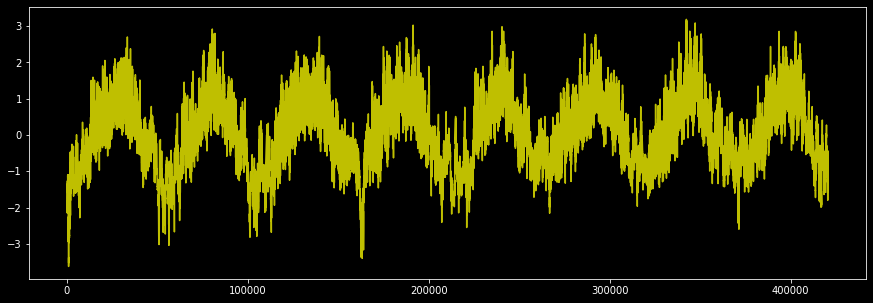

In [293]:
plt.figure(figsize=(15, 5))
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp, c= 'y')
plt.show()

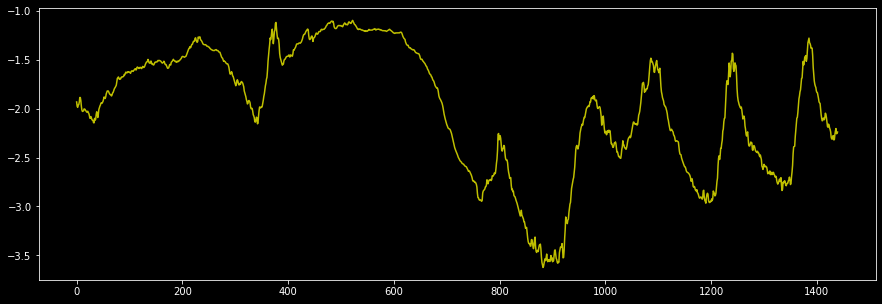

In [294]:
plt.figure(figsize=(15,5))
plt.plot(range(1440), temp[:1440], c='y')
plt.show()

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [17]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

```lookback = 432—Observations will go back 3 days (in 30 minutes intervals). (a timestep is 10 minutes)```

```steps = 3—Observations will be sampled at half an hour data point per hour.```

```delay = 18—Targets will be 3 hours in the future.```

In [49]:
lookback = 432
step = 3
delay = 18
batch_size = 128

In [50]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000,
                      shuffle=True, step=step,  batch_size=batch_size)

In [51]:
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001,
                    max_index=300000, step=step, batch_size=batch_size)

In [52]:
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None,
                     step=step, batch_size=batch_size)

In [53]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [54]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=(val_gen), validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 20ms/step - loss: 1.2841 - val_loss: 0.3767
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3208 - val_loss: 0.1877
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1912 - val_loss: 0.2100
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1695 - val_loss: 0.1686
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1586 - val_loss: 0.1426
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1543 - val_loss: 0.1503
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1501 - val_loss: 0.1385
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.1465 - val_loss: 0.1463
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1442 - val_loss: 0.1434
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.143

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

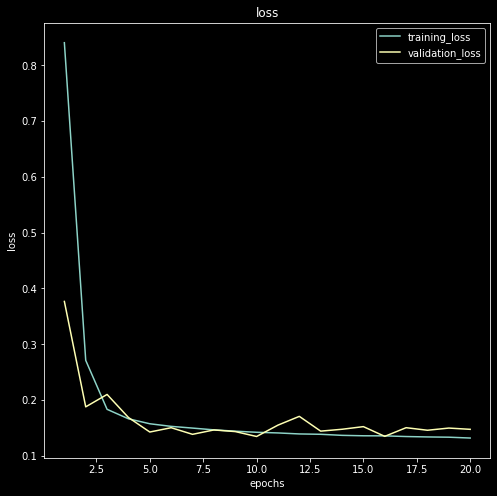

In [56]:
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, label = 'training_loss')
plt.plot(epochs, val_loss, label= 'validation_loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## validation데이터에 대한 loss의 최소값이 얼마인가?

```R: 0.1348 - epoch 16```

## Generator를 사용하지 않고 학습을 시키려고 한다. 데이터를 적절히 변환하고, 모형을 구축하라.

In [45]:
zip_path = 'C:/Users/MSI/keras/datasets/jena_climate_2009_2016.csv.zip'")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

13574144/13568290 [==============================] - 1s 0us/step


In [47]:
df = pd.read_csv(csv_path)

In [94]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [282]:
df.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.045375,-0.124718,-0.066755,-0.018352,-0.031546,-0.054370,-0.003401,-0.069762,-0.069804,0.307640,-0.005701,-0.007760,-0.063258
T (degC),-0.045375,1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
Tpot (K),-0.124718,0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
Tdew (degC),-0.066755,0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
rh (%),-0.018352,-0.572416,-0.567127,-0.156615,1.000000,-0.615842,-0.151494,-0.843835,-0.150841,-0.150969,0.514282,-0.005020,-0.009921,-0.015912
VPmax (mbar),-0.031546,0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
VPact (mbar),-0.054370,0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
VPdef (mbar),-0.003401,0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
sh (g/kg),-0.069762,0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
H2OC (mmol/mol),-0.069804,0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607


<AxesSubplot:>

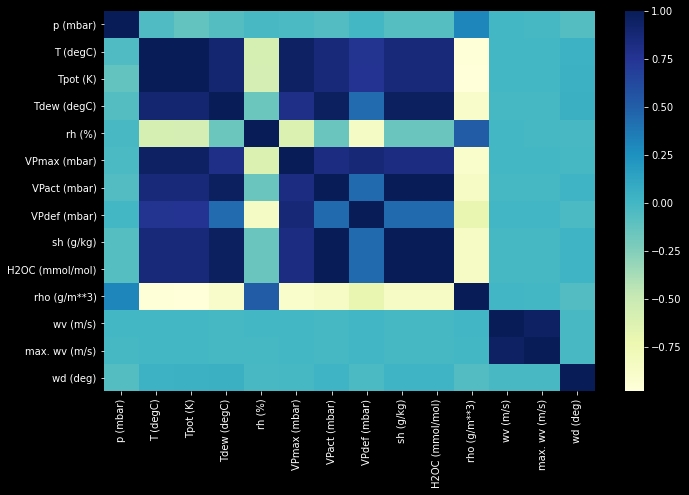

In [291]:
#see what variables should be taken out. The one with weaker correlation(yellow, white) will be taken out
plt.figure(figsize=(11,7))
sns.heatmap(df.corr(), cmap="YlGnBu")

In [83]:
split_fraction = 0.80 # 80% of data to train the model
train_split = int(split_fraction * int(df.shape[0]))
step = 3 #half an hour

past = 432 #each day is 144 observations. 3 days * 144 observations by day= 432
future = 18 # 3 hours * 6 observations in an hour (every 10 minutes there is an observation) 
learning_rate = 0.001
batch_size = 256
epochs = 20

In [60]:
def normalize(data, train_split): #a way of batchnormalization for the data
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [64]:
titles = ["Pressure","Temperature","Temperature in Kelvin","Temperature (dew point)", "Relative Humidity", 
          "Saturation vapor pressure","Vapor pressure","Vapor pressure deficit","Specific humidity","Water vapor concentration",
          "Airtight", "Wind speed","Maximum wind speed","Wind direction in degrees",]

In [66]:
feature_keys = ["p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)",
                "sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)",]

In [68]:
date_time_key = "Date Time"

In [69]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [70]:
##TRAIN DATASET

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [71]:
dataset_train = tensorflow.keras.preprocessing.timeseries_dataset_from_array(x_train, y_train,
                sequence_length=sequence_length, sampling_rate=step, batch_size=batch_size)

In [73]:
# VALIDATION DATASET

x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tensorflow.keras.preprocessing.timeseries_dataset_from_array( x_val, y_val, sequence_length=sequence_length,
              sampling_rate=step, batch_size=batch_size)

In [78]:
# MODEL
inputs = layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(lstm_out)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144, 7)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [81]:
# CALLBACKS
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

checkpoint = ModelCheckpoint(monitor="val_loss",
             filepath='C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning/model1.h5',
             verbose=1,
             save_weights_only=True,
             save_best_only=True,)

In [84]:
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, 
                    callbacks=[earlystop, checkpoint])

Epoch 1/20
1313/1313 [==============================] - 28s 21ms/step - loss: 0.0961 - val_loss: 0.0932

Epoch 00001: val_loss improved from inf to 0.09317, saving model to C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning\model1.h5
Epoch 2/20
1313/1313 [==============================] - 26s 20ms/step - loss: 0.0621 - val_loss: 0.0784

Epoch 00002: val_loss improved from 0.09317 to 0.07837, saving model to C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning\model1.h5
Epoch 3/20
1313/1313 [==============================] - 26s 20ms/step - loss: 0.0514 - val_loss: 0.0751

Epoch 00003: val_loss improved from 0.07837 to 0.07509, saving model to C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning\model1.h5
Epoch 4/20
1313/1313 [==============================] - 27s 20ms/step - loss: 0.0480 - val_loss: 0.0677

Epoch 00004: val_loss improved from 0.07509 to 0.06772, saving model to C:/Users/MSI/Desktop/Kookmin/Second semester/Deep Learning\model1.h5
Epoch 5/20
1313/1313

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']

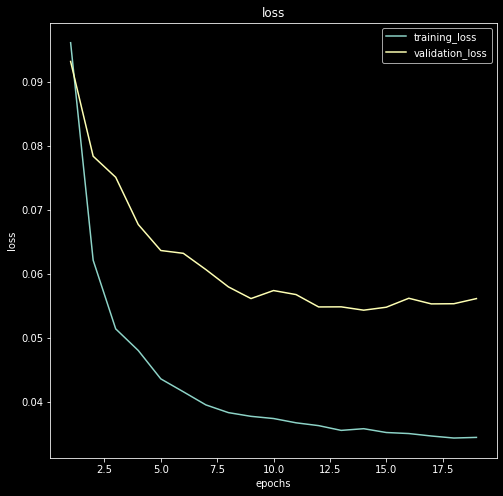

In [86]:
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, label = 'training_loss')
plt.plot(epochs, val_loss, label= 'validation_loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

```validation데이터에 대한 loss의 최소값이 얼마인가?```

R: 0.0548 - epoch 14

# 다음의 class를 보고 물음에 답하라

In [105]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [220]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    
    attention_weights = tf.nn.softmax(score,axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [107]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding_dim = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output= tf.reshape(output,(-1, output.shape[2]))
    x = self.fc(output)

    return x, state, attention_weights

In [155]:
text = [("He loves singing", "그는 노래하기를 좋아한다"),
          ("Her hair is long", "그녀의 머리카락은 길어"),
          ("Here is the bill", "여기 계산서 입니다"),
          ("I like apples", "사과를 좋아합니다")]

In [261]:
input_text = []

In [262]:
for t in text:
    input_text+=([t[0].split(' ')])

In [263]:
input_text

[['He', 'loves', 'singing'],
 ['Her', 'hair', 'is', 'long'],
 ['Here', 'is', 'the', 'bill'],
 ['I', 'like', 'apples']]

In [266]:
target_text = []

In [267]:
for t in text:
    target_text+=([t[1].split(' ')])

In [268]:
target_text

[['그는', '노래하기를', '좋아한다'],
 ['그녀의', '머리카락은', '길어'],
 ['여기', '계산서', '입니다'],
 ['사과를', '좋아합니다']]

In [270]:
s_vocab = list(set(sum(input_text, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}
print(source2idx)

{'<pad>': 0, 'He': 1, 'Her': 2, 'Here': 3, 'I': 4, 'apples': 5, 'bill': 6, 'hair': 7, 'is': 8, 'like': 9, 'long': 10, 'loves': 11, 'singing': 12, 'the': 13}


In [195]:
#korean text
t_vocab = list(set(sum(target_text, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}
print(target2idx)

{'<pad>': 0, '<bos>': 1, '<eos>': 2, '계산서': 3, '그녀의': 4, '그는': 5, '길어': 6, '노래하기를': 7, '머리카락은': 8, '사과를': 9, '여기': 10, '입니다': 11, '좋아한다': 12, '좋아합니다': 13}


In [196]:
def preprocess(sequences, max_len, dic, mode = 'source'):
  assert mode in ['source', 'target']
  if mode == 'source':
    s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
    s_len = list(map(lambda sentence : len(sentence), s_input))
    s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
    return s_len, s_input
  elif mode == 'target':
    t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
    t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
    t_len = list(map(lambda sentence : len(sentence), t_input))
    t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')
    t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
    t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
    t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')
    return t_len, t_input, t_output

In [198]:
s_max_len = 10
s_len, s_input = preprocess(sequences = input_text, max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 4, 3] [[ 1 11 12  0  0  0  0  0  0  0]
 [ 2  7  8 10  0  0  0  0  0  0]
 [ 3  8 13  6  0  0  0  0  0  0]
 [ 4  9  5  0  0  0  0  0  0  0]]


In [201]:
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = target_text, max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 5, 4] [[ 1  5  7 12  2  0  0  0  0  0  0  0]
 [ 1  4  8  6  2  0  0  0  0  0  0  0]
 [ 1 10  3 11  2  0  0  0  0  0  0  0]
 [ 1  9 13  2  0  0  0  0  0  0  0  0]] [[ 5  7 12  2  0  0  0  0  0  0  0  0]
 [ 4  8  6  2  0  0  0  0  0  0  0  0]
 [10  3 11  2  0  0  0  0  0  0  0  0]
 [ 9 13  2  0  0  0  0  0  0  0  0  0]]


## inc_out, inc_hidden = encoder(input_tensor[:2], inc_hidden)을 실행하였다고 하자. inc_hidden, inc_out, inc_hidden의 shape은 각각 무엇인가?

In [202]:
encoder = Encoder(30, 64, 32, 2)

In [203]:
inc_hidden = encoder.initialize_hidden_state()

In [204]:
out, hidden = encoder(t_input[:2], inc_hidden)

In [230]:
print("Shape inc_out:", out.shape,'\n', "Shape inc_hidden:", hidden.shape)

Shape inc_out: (2, 12, 32) 
 Shape inc_hidden: (2, 32)


## attention_result, attention_weight = attention(sample_hidden, sample_output)을 실행하였다고 하자. sample_hidden(? not attention result?)은 shape이 무엇인가

In [221]:
attention = BahdanauAttention(10)

In [227]:
attention_result, attention_weight = attention(hidden, out)

In [273]:
print("Shape attention_result:",attention_result.shape) # sample_hidden?

Shape attention_result: (2, 32)


## (2)번 문제에서 sample_hidden에는 어떤 값이 들어가는가? 설명하라

In [229]:
#설명: On each timestep t, we have decoder hidden state of St E R^h wich gives the 32 states
print("Shape inc_out:", hidden.shape)

Shape inc_out: (2, 32)


### 2)번 문제에서 sample_output은 어떤 값이 들어가는가? 설명하라

In [271]:
#설명: We use a^t to take a weighted sum of the encoder hidden states to get the attention output a^t
#we concatenate the attention output (it this case (2, 32)) with the decoder hidden state. 
print("Shape inc_out:", out.shape)

Shape inc_out: (2, 12, 32)


##  (2)번 문제에서 attention_result는 shape이 무엇인가?

In [272]:
print("Shape attention_result:",attention_result.shape)

Shape attention_sample_hidden: (2, 32)


##  (2)번 문제에서 attention_result는 어떤값이 들어가는가? 설명하라

In [275]:
attention_result

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[-0.03167725, -0.00594679, -0.00013391, -0.01677235,  0.01627953,
        -0.02546324,  0.02877193,  0.00584858, -0.00822813, -0.01064357,
        -0.01376328,  0.00245871, -0.01656461,  0.01085459,  0.00794529,
        -0.0022663 ,  0.00372688, -0.01004836, -0.0004979 , -0.00976531,
         0.00527197,  0.02903646, -0.01366027, -0.0160713 , -0.01022416,
        -0.01826399, -0.00557275,  0.01015081, -0.00252986, -0.00805306,
        -0.00186276, -0.00785604],
       [-0.02691532, -0.01290876, -0.00281733, -0.01599995,  0.02487755,
        -0.02805658,  0.01577726,  0.00132019, -0.01830185, -0.00556698,
        -0.01022077,  0.00749586, -0.0194175 ,  0.01536748,  0.00405347,
        -0.00301353, -0.00085251, -0.00524445, -0.00546666, -0.00243679,
         0.0021646 ,  0.03515249, -0.01824849, -0.01157084, -0.00530702,
        -0.02275976, -0.00822803,  0.0114193 ,  0.00683378, -0.00270147,
        -0.00827496, -0.01213802]], dtyp

```Due to this part of the code in the BahdanauAttention class 
   (context_vector = attention_weights * values
   context_vector = tf.reduce_sum(context_vector, axis=1) 
   we sum the batch size and the hidden_size of the input (processed by the BahdanauAttention class)```